In [13]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

#@njit(fastmath=True)
def nY_fast(t, tn, yn,dyn, D,l):
    sol = yn # initial conditon
    sol += t**2-tn**2 -(t**5-tn**5)/5 # source  
    sol += (t-tn)*yn**2 # 0 order control
    sol += 2*((t**2-tn**2)/2 - tn*(t-tn))*yn*dyn # 1 order control
    #l = 10 # >1 russian roulette parameter 
    if random()*l < (t-tn)/D:
        S = tn + random()*(t-tn)  # \sim Uniform(T,t)
        sol += l*D*(nY_fast(S, tn, yn, dyn, D,l)*nY_fast(S, tn, yn, dyn, D,l)
                     -yn**2-2*(S-tn)*yn*dyn) 
        global nrec
        nrec+=1
    return sol 


#@njit(fastmath=True)
def nY_slow(t, D: "step size slow recursion",l):
    yn,tn = 0,0
    while tn<t:
        tt = tn+D if tn+D<t else t
        dyn = yn**2 -tn**4+2*tn 
        yn = nY_fast(tt, tn, yn,dyn, tt-tn,l) 
        tn=tt
        global points
        points += [(tn,yn)]
    return yn


@njit(fastmath=True, parallel=True)
def nsol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += nY_slow(T,DT)
    return total/nsim

average nrec=0.609375
average nrec=0.6953125
average nrec=0.0
average nrec=0.0


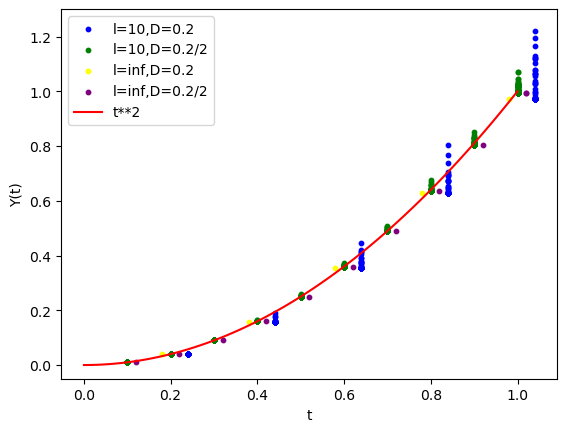

In [14]:
nsim = 64
s = 10
l=10
k = 2
points =[] 
nrec =0

for _ in range(nsim):
    nY_slow(1,0.2,l)
x,yn = zip(*points)
x = np.array(x)+0.04
plt.scatter(x,yn,color="blue",s=s,label=f"l={l},D=0.2")
print(f"average nrec={nrec/nsim}")

points =[] 
nrec =0
for _ in range(nsim):
    nY_slow(1,0.2/k,l)
x,yn = zip(*points)
x = np.array(x)
plt.scatter(x,yn,color="green",s=s,label=f"l={l},D=0.2/{k}")
print(f"average nrec={nrec/(k*nsim)}")

points =[] 
nrec =0

nY_slow(1,0.2,float("inf"))
x,yn = zip(*points)
x = np.array(x)-0.02
plt.scatter(x,yn,color="yellow",s=s,label="l=inf,D=0.2")
print(f"average nrec={nrec/nsim}")

points =[] 
nrec =0

nY_slow(1,0.2/k,float("inf"))
x,yn = zip(*points)
x = np.array(x)+0.02
plt.scatter(x,yn,color="purple",s=s,label=f"l=inf,D=0.2/{k}")
print(f"average nrec={nrec/(k*nsim)}")

ll = np.arange(0,1.01,0.01)
plt.plot(ll,ll**2,color ="red",label="t**2")

plt.ylim(-0.05,1.3)
plt.xlabel("t")
plt.ylabel("Y(t)")
plt.legend()
plt.show()
